In [ ]:
# TODO: Read: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/2309.11798v4
# and https://www.nature.com/articles/s41598-024-58624-4 and https://www.nature.com/articles/s41598-024-58624-4
# chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.aimspress.com/aimspress-data/math/2024/2/PDF/math-09-02-178.pdf
# https://ieeexplore.ieee.org/abstract/document/7289461?casa_token=fHhNEidoqJMAAAAA:LM6FsCabVYqQ36U10oWBJSYUmAL4X1_yraUZv51GF3vsfDsp15CrrOFpI-o7PRtfX_JPd9Gog3AGcHQ

In [ ]:
# TODO: Fix the fact that rent is not being added correctly to the edges

In [1]:
import config as cfg
from utils import *
import seaborn as sns
import numpy as np

In [2]:
# Load data
all_viajes = pd.read_csv('/Users/caro/Desktop/thesis_project/mobility_data/VIAJES/all_viajes_month_0322.csv')
income = gpd.read_file('/Users/caro/Desktop/thesis_project/segregation_indices/data/processed/geometries_and_income.geojson')
gdf = gpd.read_file(cfg.ZONIFICACION_DATA / 'distritos/madrid_gdf.geojson')  # Load your GeoJSON file into a GeoDataFrame
gdf = gdf.to_crs(epsg=4326) # I am having problems with the Pyproj package

In [3]:
# Filter data
filtered_df = all_viajes.loc[(all_viajes['actividad_origen'] == 'casa')]
home_work = all_viajes[((all_viajes['actividad_origen'] == 'casa') & (all_viajes['actividad_destino'] == 'trabajo_estudio'))]

In [4]:
income['Gini Index Scaled'] = income['Gini Index'] ** 2.5

In [5]:
var_of_interest = 'Median income per consumption unit'
var_of_interest_2 = 'Gini Index Scaled'

In [6]:
G, trip_counts = define_graph(filtered_df, remove_weak_edges=False, threshold=0.25)
G = update_node_sizes(G, income, var_of_interest_2)
positions = get_positions(gdf)
edge_widths = set_art(G, 0.1)
plotly_graph(G, positions, edge_widths, var_of_interest_2, node_size_scale=0.006)

In [7]:
id_to_name = district_mapping.set_index('ID')['name_2'].to_dict()
G = nx.relabel_nodes(G, id_to_name)

In [8]:
# saving graph
import pickle
pickle.dump(G, open('graphs/march_22_home_origin.pickle', 'wb'))

In [8]:
G2, trip_counts2 = define_graph(home_work, remove_weak_edges=False, threshold=0.27)
G2 = update_node_sizes(G2, income, var_of_interest)
positions = get_positions(gdf)
edge_widths = set_art(G2, 0.1)
plotly_graph(G2, positions, edge_widths, var_of_interest, node_size_scale=0.006)

In [9]:
G2, trip_counts2 = define_graph(home_work, remove_weak_edges=True, threshold=0.27)
G2 = update_node_sizes(G2, income, var_of_interest)
positions = get_positions(gdf)
edge_widths = set_art(G2, 0.1)
plotly_graph(G2, positions, edge_widths, var_of_interest, node_size_scale=0.002)

In [10]:
id_to_name = district_mapping.set_index('ID')['name_2'].to_dict()
G2 = nx.relabel_nodes(G2, id_to_name)

In [11]:
# adj_matrix = nx.adjacency_matrix(G, weight='weight').toarray()
# np.save('adjacency_matrices/filtered_df.npy', adj_matrix)

In [20]:
adj_matrix = get_adj_matrix(G)

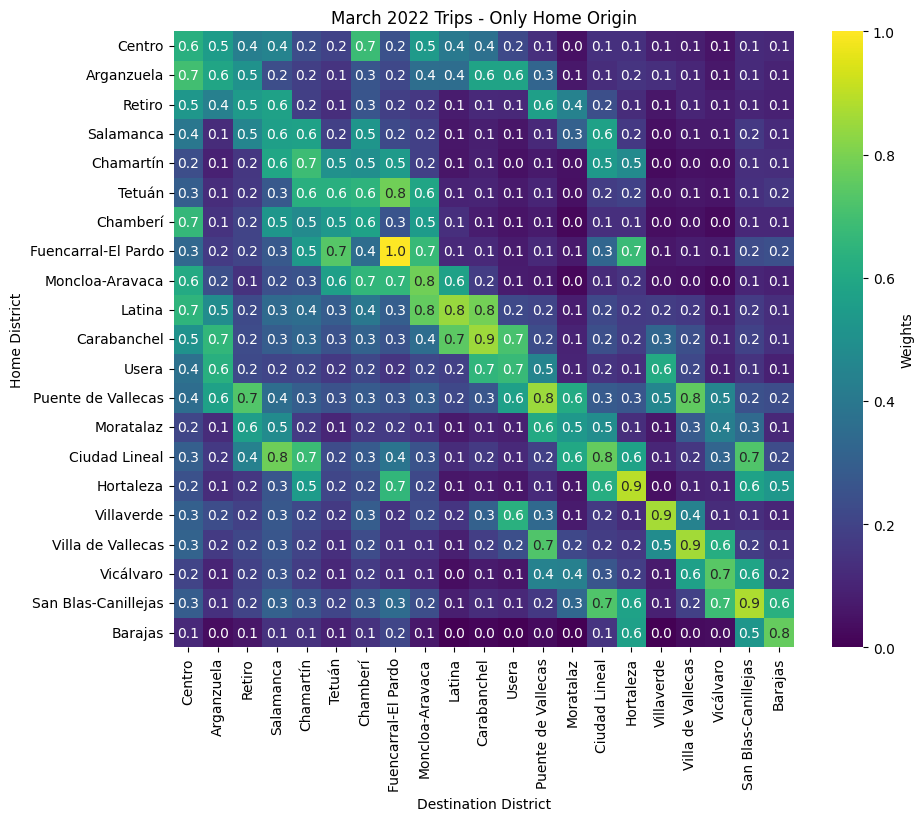

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    adj_matrix, 
    annot=True, 
    cmap='viridis', 
    cbar_kws={'label': 'Weights'}, 
    fmt=".1f"
)
plt.title('March 2022 Trips - Only Home Origin')
plt.xlabel('Destination District')
plt.ylabel('Home District');

## General Statistics

In [18]:
G.size(weight="weight")

np.float64(123.61733307181483)

In [45]:
#degree_df = pd.DataFrame(nx.degree(G, weight='weight'),columns=["ID", "degree"])
#degree_df.sort_values("degree", ascending=False)

In [19]:
len(G.edges)

441

In [46]:
#nx.average_clustering(G, weight='weight')

In [47]:
#nx.eigenvector_centrality(G, weight='weight')

In [48]:
#nx.betweenness_centrality(G, weight='weight')

In [49]:
#nx.shortest_path(G, source=2807901, target=2807921, weight='weight')

In [50]:
#print_node_degrees(G)

In [51]:
# Check total in-weights for each node
#in_weights = check_in_weights(G)

In [52]:
# Check total out-weights for each node
#out_weights = check_out_weights(G)

In [35]:
adj_matrix = get_adj_matrix(G)

In [43]:
# nx.write_gml(G, "0322_home_origin_graph.gml")

## Testing Infomap

In [23]:
edges_with_weights = [(u, v, data['weight']) for u, v, data in G.edges(data=True)]

df_edges = pd.DataFrame(edges_with_weights, columns=['source', 'target', 'weight'])
df_edges = df_edges[df_edges['weight'] >= 0.3] # NOTE: Infomap only finds 1 community if I leave edges as they are. Hence, I had to cut edges 

df_edges.to_csv('infomap_input.txt', sep=' ', header=False, index=False)

In [52]:
df_edges

,source,target,weight
0,2807901,2807901,0.629914
1,2807901,2807902,0.548320
2,2807901,2807903,0.424445
3,2807901,2807904,0.448233
6,2807901,2807907,0.680910
...,...,...,...
418,2807920,2807920,0.876657
419,2807920,2807921,0.633192
435,2807921,2807916,0.566085
439,2807921,2807920,0.526633


## Community Analysis

In [19]:
communities = nx.community.louvain_communities(G, weight='weight', seed=1234)

In [20]:
len(communities)

4

In [21]:
def average_degree_per_community(G, communities):
    community_avg_in_degrees = []
    community_avg_out_degrees = []
    
    for community in communities:
        in_degrees = [G.in_degree(node,  weight='weight') for node in community]  # Get in-degree for each node
        out_degrees = [G.out_degree(node,  weight='weight') for node in community] 
        avg_in_degree = sum(in_degrees) / len(community)        # Compute average in-degree
        avg_out_degree = sum(out_degrees) / len(community)
        community_avg_in_degrees.append(avg_in_degree)
        community_avg_out_degrees.append(avg_out_degree)
        print(f"Community {community} - Average In-degree: {avg_in_degree} - Average Out-degree: {avg_out_degree}")
    
    return community_avg_in_degrees, community_avg_out_degrees

# Calculate and display average in-degree for each community
average_degree_per_community(G, communities)

Community {np.float64(2807904.0), np.float64(2807905.0), np.float64(2807906.0), np.float64(2807907.0), np.float64(2807908.0), np.float64(2807909.0), np.float64(2807901.0)} - Average In-degree: 4.04637810322813 - Average Out-degree: 4.085801449713595
Community {np.float64(2807910.0), np.float64(2807911.0), np.float64(2807912.0), np.float64(2807917.0), np.float64(2807902.0)} - Average In-degree: 2.8010069155819113 - Average Out-degree: 2.7543263092044943
Community {np.float64(2807913.0), np.float64(2807914.0), np.float64(2807903.0), np.float64(2807918.0), np.float64(2807919.0)} - Average In-degree: 2.6553743583591127 - Average Out-degree: 2.641770286135415
Community {np.float64(2807920.0), np.float64(2807921.0), np.float64(2807915.0), np.float64(2807916.0)} - Average In-degree: 3.1932774459479143 - Average Out-degree: 3.1996424378497426


([np.float64(4.04637810322813),
  np.float64(2.8010069155819113),
  np.float64(2.6553743583591127),
  np.float64(3.1932774459479143)],
 [np.float64(4.085801449713595),
  np.float64(2.7543263092044943),
  np.float64(2.641770286135415),
  np.float64(3.1996424378497426)])